In [1]:
import sys
sys.path.append('../src')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, count
import pyspark.sql.functions as F
import folium
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose

from data_preprocessing import convert_citibike_zip_to_parquet, load_parquet_in_spark, fetch_data

### Dataset 1: Citibike Data

#### Load Data

In [4]:
citibike_data_zip_path = '../data/raw/2023-citibike-tripdata.zip'
processed_data_output_path = '../data/processed/citibike/'
trip_data = load_parquet_in_spark(os.path.join(processed_data_output_path,'trips/'))
print(f"Total number of records: {trip_data.count()}")

Total number of records: 92075958


#### Clean Data

In [5]:
# Filter out trips outside OF 2023 date range
trip_data = trip_data.withColumn("date", F.to_date("started_at"))
total_trips = trip_data.count()
trips_outside_range = trip_data.filter((F.col("date") < "2023-01-01") | (F.col("date") > "2023-12-31")).count()
percentage_outside_range = (trips_outside_range / (total_trips + trips_outside_range)) * 100
print(f"Number of trips outside the 2023-2024 range: {trips_outside_range} ({percentage_outside_range:.2f}%)")
print("We will discard these trips as we consider them outliers.")
trip_data = trip_data.filter((F.col("date") >= "2023-01-01") & (F.col("date") <= "2023-12-31"))

# Filter out trips with a duration shorter then 5 mins and longer than 300 mins
x_threshold = 300  # upper threshold
y_threshold = 5    # lower threshold
trip_data = trip_data.withColumn(
    "duration_minutes",
    F.round((F.unix_timestamp("ended_at") - F.unix_timestamp("started_at")) / 60).cast("integer")
)
total_trips = trip_data.count()
trips_longer_than_x = trip_data.filter(F.col("duration_minutes") > x_threshold).count()
trips_shorter_than_y = trip_data.filter(F.col("duration_minutes") < y_threshold).count()
percentage_longer_than_x = (trips_longer_than_x / total_trips) * 100
percentage_shorter_than_y = (trips_shorter_than_y / total_trips) * 100
print(f"Number of trips shorter than {y_threshold} minutes: {trips_shorter_than_y} ({percentage_shorter_than_y:.2f}%)")
print(f"Number of trips longer than {x_threshold} minutes: {trips_longer_than_x} ({percentage_longer_than_x:.2f}%)")
print("We will discard these trips as we consider them outliers.")
trip_data = trip_data.filter(
    (F.col("duration_minutes") >= y_threshold) & (F.col("duration_minutes") <= x_threshold)
)
print(f"Total number of filtered records: {trip_data.count()}")

Number of trips outside the 2023-2024 range: 56969248 (38.22%)
We will discard these trips as we consider them outliers.
Number of trips shorter than 5 minutes: 6663485 (18.98%)
Number of trips longer than 300 minutes: 63099 (0.18%)
We will discard these trips as we consider them outliers.
Total number of filtered records: 28380126


In [6]:
trip_data.show()

+-------------+-------------------+-------------------+----------------+--------------+-------------+----------+----------------+
|rideable_type|         started_at|           ended_at|start_station_id|end_station_id|member_casual|      date|duration_minutes|
+-------------+-------------------+-------------------+----------------+--------------+-------------+----------+----------------+
| classic_bike|2023-01-04 19:23:01|2023-01-04 19:34:57|         5391.06|       5626.13|       member|2023-01-04|              12|
| classic_bike|2023-01-20 09:22:19|2023-01-20 10:23:24|         4437.01|       4522.07|       member|2023-01-20|              61|
|electric_bike|2023-01-13 10:17:38|2023-01-13 10:33:59|         6955.05|       6039.06|       member|2023-01-13|              16|
| classic_bike|2023-01-26 19:17:23|2023-01-26 19:47:05|         7023.04|       5593.01|       member|2023-01-26|              30|
|electric_bike|2023-01-13 12:25:17|2023-01-13 12:38:53|         6955.05|       6039.06|   

#### Bike Types Distribution

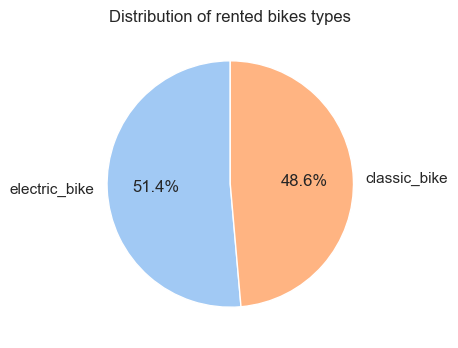

In [7]:
rideable_counts = trip_data.groupBy("rideable_type").count()
rideable_counts_pd = rideable_counts.toPandas()

sns.set_theme(style="ticks")
colors = sns.color_palette("pastel", 4)[:2]

plt.figure(figsize=(6, 4))
plt.pie(
    rideable_counts_pd['count'],
    labels=rideable_counts_pd['rideable_type'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Distribution of rented bikes types')
plt.show()

#### Clients ? Casual vs Member

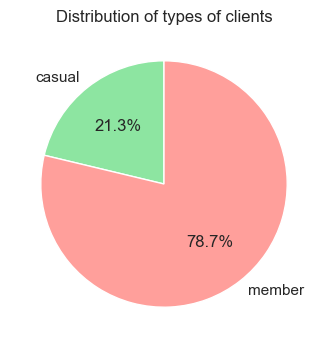

In [8]:
client_type_counts = trip_data.groupBy("member_casual").count()
client_type_counts_pd = client_type_counts.toPandas()

sns.set_theme(style="ticks")
colors = sns.color_palette("pastel", 4)[2:4]

plt.figure(figsize=(6, 4))
plt.pie(
    client_type_counts_pd['count'],
    labels=client_type_counts_pd['member_casual'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Distribution of types of clients')
plt.show()

#### Distribution of trip duration

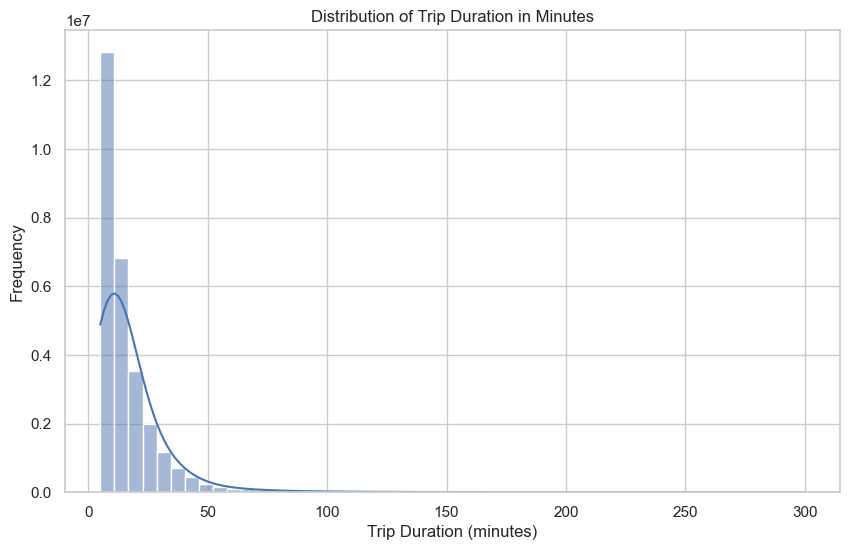

In [9]:
# Group by duration_minutes and get the count, then convert to Pandas
duration_counts = trip_data.groupBy("duration_minutes").count()
duration_counts_pd = duration_counts.toPandas()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=duration_counts_pd, x="duration_minutes", weights="count", bins=50, kde=True)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Duration in Minutes')
plt.show()

#### Dstribution of Citibike Trips Across 2023

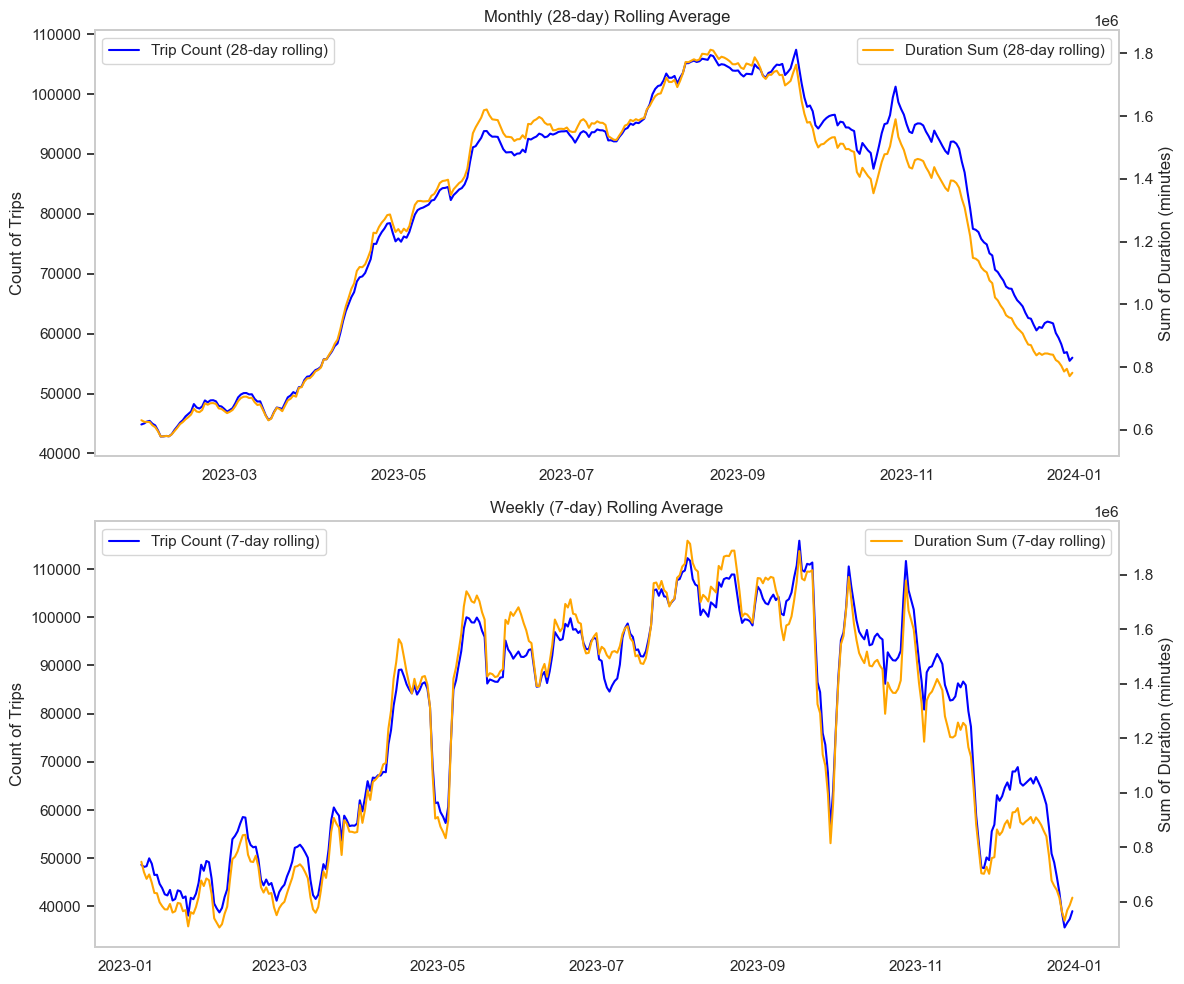

In [17]:
# Group by date and calculate daily trip count and duration sum
citibike_trips_daily = trip_data.groupBy("date").agg(
    F.count("*").alias("trip_count"),
    F.sum("duration_minutes").alias("duration_sum")
)

# Convert to Pandas and set up for rolling averages
citibike_trips_daily_pd = citibike_trips_daily.orderBy("date").toPandas()
citibike_trips_daily_pd['date'] = pd.to_datetime(citibike_trips_daily_pd['date'])
citibike_trips_daily_pd.set_index('date', inplace=True)

# Rolling averages for monthly (28 days) and weekly (7 days)
citibike_trips_daily_pd['trip_count_rolling_28'] = citibike_trips_daily_pd['trip_count'].rolling(window=28).mean()
citibike_trips_daily_pd['duration_sum_rolling_28'] = citibike_trips_daily_pd['duration_sum'].rolling(window=28).mean()
citibike_trips_daily_pd['trip_count_rolling_7'] = citibike_trips_daily_pd['trip_count'].rolling(window=7).mean()
citibike_trips_daily_pd['duration_sum_rolling_7'] = citibike_trips_daily_pd['duration_sum'].rolling(window=7).mean()

# plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot rolling monthly averages (28 days)
ax1 = axes[0]
ax1.plot(citibike_trips_daily_pd.index, citibike_trips_daily_pd['trip_count_rolling_28'], label='Trip Count (28-day rolling)', color='blue')
ax1.set_ylabel("Count of Trips")
#ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_title("Monthly (28-day) Rolling Average")
ax1.legend(loc='upper left')
ax1.grid(visible=False)

# Right y-axis for duration sum (28 days)
ax2 = ax1.twinx()
ax2.plot(citibike_trips_daily_pd.index, citibike_trips_daily_pd['duration_sum_rolling_28'], label='Duration Sum (28-day rolling)', color='orange')
ax2.set_ylabel("Sum of Duration (minutes)")
#ax2.tick_params(axis="y", labelcolor="orange")
ax2.legend(loc='upper right')
ax2.grid(visible=False)

# Plot rolling weekly averages (7 days)
ax3 = axes[1]
ax3.plot(citibike_trips_daily_pd.index, citibike_trips_daily_pd['trip_count_rolling_7'], label='Trip Count (7-day rolling)', color='blue')
ax3.set_ylabel("Count of Trips")
#ax3.tick_params(axis="y", labelcolor="blue")
ax3.set_title("Weekly (7-day) Rolling Average")
ax3.legend(loc='upper left')
ax3.grid(visible=False)

# Right y-axis for duration sum (7 days)
ax4 = ax3.twinx()
ax4.plot(citibike_trips_daily_pd.index, citibike_trips_daily_pd['duration_sum_rolling_7'], label='Duration Sum (7-day rolling)', color='orange')
ax4.set_ylabel("Sum of Duration (minutes)")
#ax4.tick_params(axis="y", labelcolor="orange")
ax4.legend(loc='upper right')
ax4.grid(visible=False)

# Show plot
#plt.xlabel("Date")
plt.tight_layout()
plt.savefig('../results/monthly rolling_average_trips_2023.jpg')
plt.show()

#### Trend / Seasonality Analysis

In [11]:
trip_data_extended = load_parquet_in_spark(os.path.join(processed_data_output_path,'trips/'))
print(f"Total number of records: {trip_data_extended.count()}")

Total number of records: 92075958


In [12]:
# Filter out trips outside OF 2021-2023 date range
trip_data_extended = trip_data_extended.withColumn("date", F.to_date("started_at"))
total_trips = trip_data_extended.count()
trips_outside_range = trip_data_extended.filter((F.col("date") < "2021-01-01") | (F.col("date") > "2023-12-31")).count()
percentage_outside_range = (trips_outside_range / (total_trips + trips_outside_range)) * 100
print(f"Number of trips outside the 2021-2024 range: {trips_outside_range} ({percentage_outside_range:.2f}%)")
print("We will discard these trips as we consider them outliers.")
trip_data_extended = trip_data_extended.filter((F.col("date") >= "2021-01-01") & (F.col("date") <= "2023-12-31"))

# Filter out trips with a duration shorter then 5 mins and longer than 300 mins
x_threshold = 300  # upper threshold
y_threshold = 5    # lower threshold
trip_data_extended = trip_data_extended.withColumn(
    "duration_minutes",
    F.round((F.unix_timestamp("ended_at") - F.unix_timestamp("started_at")) / 60).cast("integer")
)
total_trips = trip_data_extended.count()
trips_longer_than_x = trip_data_extended.filter(F.col("duration_minutes") > x_threshold).count()
trips_shorter_than_y = trip_data_extended.filter(F.col("duration_minutes") < y_threshold).count()
percentage_longer_than_x = (trips_longer_than_x / total_trips) * 100
percentage_shorter_than_y = (trips_shorter_than_y / total_trips) * 100
print(f"Number of trips shorter than {y_threshold} minutes: {trips_shorter_than_y} ({percentage_shorter_than_y:.2f}%)")
print(f"Number of trips longer than {x_threshold} minutes: {trips_longer_than_x} ({percentage_longer_than_x:.2f}%)")
print("We will discard these trips as we consider them outliers.")
trip_data_extended = trip_data_extended.filter(
    (F.col("duration_minutes") >= y_threshold) & (F.col("duration_minutes") <= x_threshold)
)
print(f"Total number of filtered records: {trip_data_extended.count()}")

Number of trips outside the 2021-2024 range: 1009 (0.00%)
We will discard these trips as we consider them outliers.
Number of trips shorter than 5 minutes: 15340021 (16.66%)
Number of trips longer than 300 minutes: 206815 (0.22%)
We will discard these trips as we consider them outliers.
Total number of filtered records: 76528113


In [13]:
# Group by date and calculate daily trip count and duration sum
citibike_trips_daily_extended = trip_data_extended.groupBy("date").agg(
    F.count("*").alias("trip_count"),
    F.sum("duration_minutes").alias("duration_sum")
)

# Convert to Pandas and set up
citibike_trips_daily_extended_pd = citibike_trips_daily_extended.orderBy("date").toPandas()
citibike_trips_daily_extended_pd['date'] = pd.to_datetime(citibike_trips_daily_extended_pd['date'])
citibike_trips_daily_extended_pd.set_index('date', inplace=True)

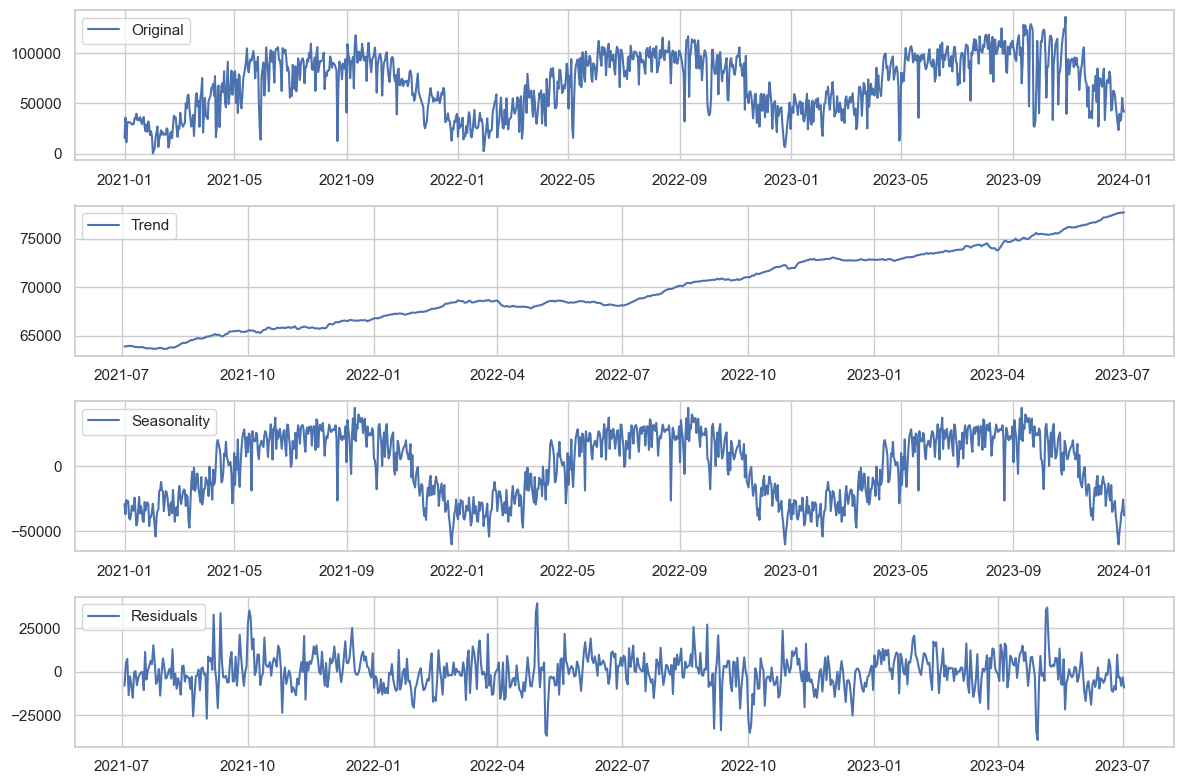

In [14]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(citibike_trips_daily_extended_pd['trip_count'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(citibike_trips_daily_extended_pd['trip_count'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('../results/seasonality_trend_citibike.jpg')
plt.show()

#### Distribution of Citibik Trips across the day

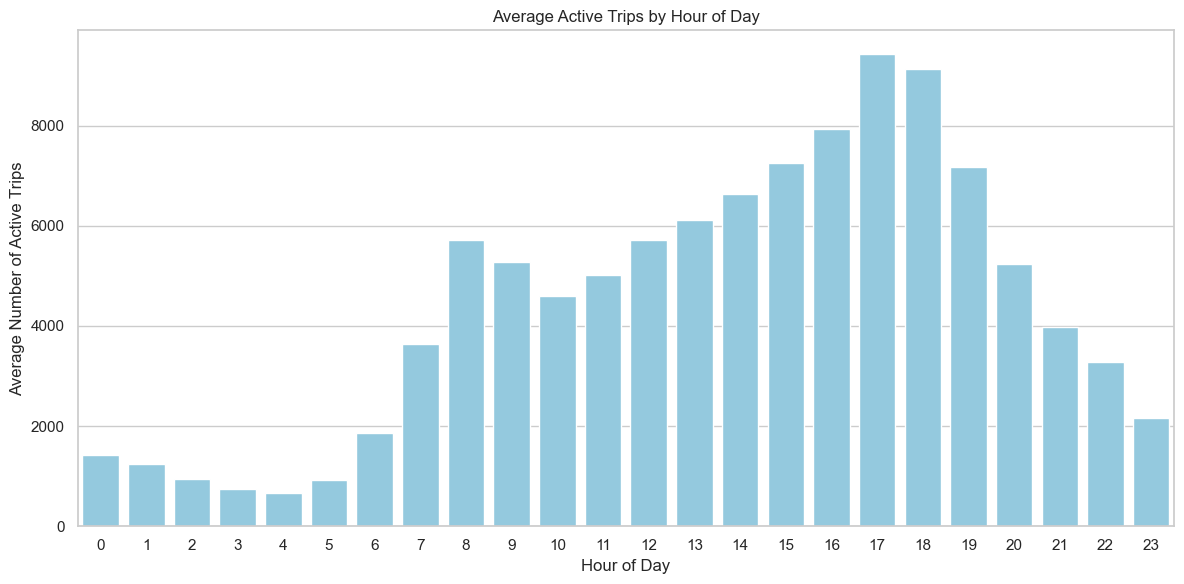

In [18]:
# Extract the start and end hours and date for each trip
trip_data = trip_data.withColumn("start_hour", F.hour("started_at"))
trip_data = trip_data.withColumn("end_hour", F.hour("ended_at"))
trip_data = trip_data.withColumn("start_date", F.to_date("started_at"))
trip_data = trip_data.withColumn("end_date", F.to_date("ended_at"))

# Expand trips to cover each hour they're active
expanded_trip_data = trip_data.select(
    "start_hour", "end_hour", "start_date", "end_date",
    F.expr("sequence(start_hour, end_hour)").alias("active_hours")
).withColumn("active_hour", F.explode("active_hours"))

# Adjust for trips that span into the next day
expanded_trip_data = expanded_trip_data.withColumn(
    "active_date", 
    F.when(F.col("active_hour") < F.col("start_hour"), F.date_add("start_date", 1)).otherwise(F.col("start_date"))
)

# Calculate average activity per hour
hourly_counts = expanded_trip_data.groupBy("active_hour").count()
total_days = expanded_trip_data.select("active_date").distinct().count()
hourly_counts = hourly_counts.withColumn("average_activity", F.col("count") / total_days)

# Convert to Pandas for plotting
hourly_counts_pd = hourly_counts.orderBy("active_hour").toPandas()

# Plotting the average activity by hour
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_counts_pd, x="active_hour", y="average_activity", color="skyblue")
plt.xlabel("Hour of Day")
plt.ylabel("Average Number of Active Trips")
plt.title("Average Active Trips by Hour of Day")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig('../results/aveg_active_trips_hourly.jpg')
plt.show()

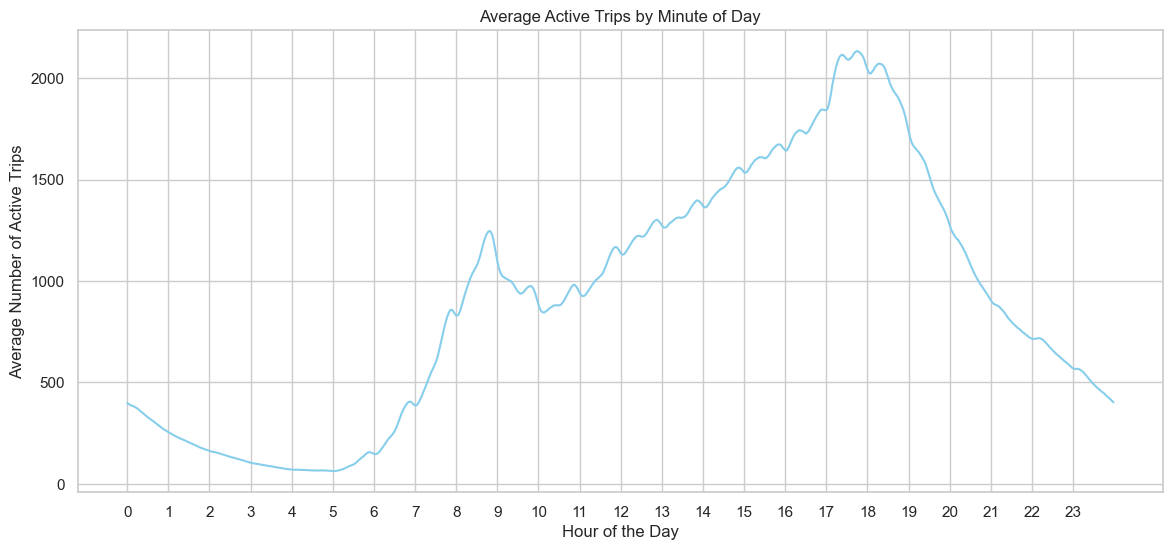

In [16]:
# Extract start and end minutes of the day and the respective dates
trip_data = trip_data.withColumn("start_minute", F.hour("started_at") * 60 + F.minute("started_at"))
trip_data = trip_data.withColumn("end_minute", F.hour("ended_at") * 60 + F.minute("ended_at"))
trip_data = trip_data.withColumn("start_date", F.to_date("started_at"))
trip_data = trip_data.withColumn("end_date", F.to_date("ended_at"))

# Flag trips that span multiple days
trip_data = trip_data.withColumn("is_multi_day", F.when(F.col("end_date") > F.col("start_date"), True).otherwise(False))

# Process single-day trips
single_day_trips = (
    trip_data.filter(~F.col("is_multi_day"))
    .withColumn("active_minutes", F.expr("sequence(start_minute, end_minute)"))
    .select(F.col("start_date").alias("day"), "active_minutes")
)

# Process multi-day trips
multi_day_trips = (
    trip_data.filter(F.col("is_multi_day"))
    .withColumn("day_seq", F.expr("sequence(start_date, end_date, interval 1 day)"))
    .withColumn("day", F.explode("day_seq"))
    .withColumn(
        "active_minutes",
        F.when(
            F.col("day") == F.col("start_date"),
            F.expr("sequence(start_minute, 1439)")  # From start_minute to end of day
        )
        .when(
            F.col("day") == F.col("end_date"),
            F.expr("sequence(0, end_minute)")  # From beginning of day to end_minute
        )
        .otherwise(F.expr("sequence(0, 1439)"))  # Full day for middle days in multi-day trips
    )
    .select("day", "active_minutes")  # Only keep necessary columns
)

# Combine single-day and multi-day trips
expanded_trip_data = single_day_trips.unionByName(multi_day_trips)

# Expand trips to cover each active minute
expanded_trip_data = expanded_trip_data.select("day", F.explode("active_minutes").alias("active_minute"))

# Calculate average activity per minute
minute_counts = expanded_trip_data.groupBy("active_minute").count()
total_days = expanded_trip_data.select("day").distinct().count()
minute_counts = minute_counts.withColumn("average_activity", F.col("count") / total_days)

# Convert to Pandas for plotting
minute_counts_pd = minute_counts.orderBy("active_minute").toPandas()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))
sns.lineplot(data=minute_counts_pd, x="active_minute", y="average_activity", color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Number of Active Trips")
plt.title("Average Active Trips by Minute of Day")
plt.xticks(ticks=range(0, 1440, 60), labels=[f"{h}" for h in range(24)])  # Label each hour
plt.show()

### Dataset 2: NYPD Crashes

In [59]:
# Define the date range
start_date = "2023-01-01" #"YYYY-MM-DD"
end_date = "2023-12-31"
date_column_name = 'crash_date'

# Socrata data ID and app token
data_id = "h9gi-nx95"
app_token = "stS0lve6TTmD6sGkuwdbI6Fhi"

# Construct the SQL query
sql_query = (
    f"SELECT * "
    f"WHERE {date_column_name} BETWEEN '{start_date}' AND '{end_date}' "
    f"AND (number_of_cyclist_injured > 0 OR number_of_cyclist_killed > 0 "
    f"OR (vehicle_type_code1 IS NOT NULL AND (vehicle_type_code1 LIKE '%bicycle%' OR vehicle_type_code1 LIKE '%bike%')) "
    f"OR (vehicle_type_code2 IS NOT NULL AND (vehicle_type_code2 LIKE '%bicycle%' OR vehicle_type_code2 LIKE '%bike%')) "
    f"OR (vehicle_type_code_3 IS NOT NULL AND (vehicle_type_code_3 LIKE '%bicycle%' OR vehicle_type_code_3 LIKE '%bike%')) "
    f"OR (vehicle_type_code_4 IS NOT NULL AND (vehicle_type_code_4 LIKE '%bicycle%' OR vehicle_type_code_4 LIKE '%bike%')))"
)
# sql_query = (
#     f"SELECT * "
#     f"WHERE {date_column_name} BETWEEN '{start_date}' AND '{end_date}' "
#     f"AND (number_of_cyclist_injured > 0 OR number_of_cyclist_killed > 0)"
# )

df_accidents = fetch_data(data_id=data_id, app_token=app_token, sql_query=sql_query)

In [63]:
# Define the date range
start_date = "2023-01-01" #"YYYY-MM-DD"
end_date = "2023-12-31"
date_column_name = 'crash_date'

# Socrata data ID and app token
data_id = "h9gi-nx95"
app_token = "stS0lve6TTmD6sGkuwdbI6Fhi"

# Construct the SQL query


df_accidents = fetch_data(data_id=data_id, app_token=app_token, sql_query=sql_query)
print(f'Total Number of Accidents in 2023{len(df_accidents)}')
df_accidents.head(3)

Total Number of Accidents in 20235304


,crash_date,crash_time,latitude,longitude,location,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,zip_code,contributing_factor_vehicle_2,vehicle_type_code2,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
0,2023-01-01T00:00:00.000,5:30,40.70481,-73.93932,"{'latitude': '40.70481', 'longitude': '-73.939...",SEIGEL STREET,BUSHWICK AVENUE,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01T00:00:00.000,1:20,40.75898,-73.96244,"{'latitude': '40.75898', 'longitude': '-73.962...",1 AVENUE,EAST 58 STREET,1,0,0,...,10022,Driver Inattention/Distraction,Sedan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01T00:00:00.000,8:40,40.762417,-73.95699,"{'latitude': '40.762417', 'longitude': '-73.95...",EAST 65 STREET,YORK AVENUE,1,0,0,...,10065,Passing or Lane Usage Improper,Sedan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


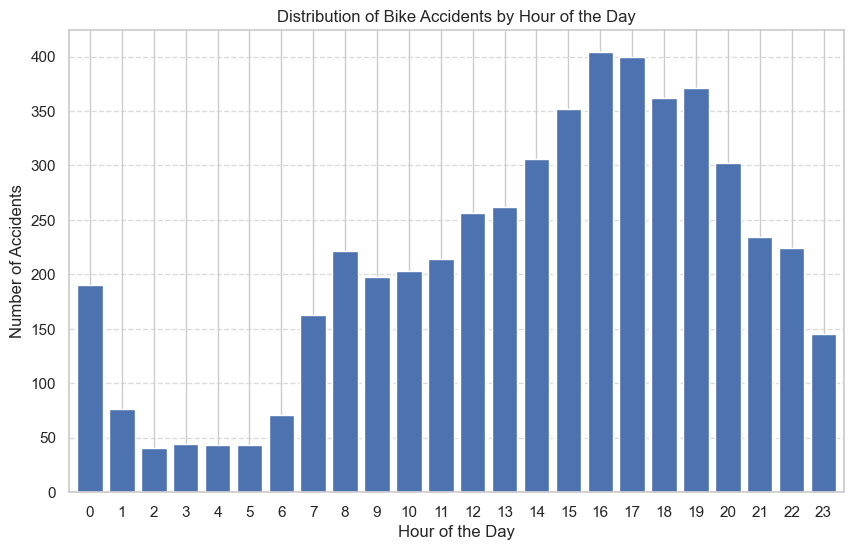

In [17]:
plt.figure(figsize=(10, 6))
pd.to_datetime(df_accidents['crash_time'], format='%H:%M', errors='coerce').dt.hour.value_counts().sort_index().plot(kind='bar', width=0.8)
plt.title('Distribution of Bike Accidents by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
df_accidents['contributing_factor_vehicle_1'].value_counts()

contributing_factor_vehicle_1
Driver Inattention/Distraction                           1570
Unspecified                                               985
Failure to Yield Right-of-Way                             644
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion     443
Traffic Control Disregarded                               287
Passing or Lane Usage Improper                            189
Following Too Closely                                     161
Unsafe Speed                                              141
Turning Improperly                                        107
Other Vehicular                                            98
Driver Inexperience                                        73
View Obstructed/Limited                                    72
Passing Too Closely                                        62
Passenger Distraction                                      49
Unsafe Lane Changing                                       39
Alcohol Involvement                     

In [19]:
# Initialize the map centered around New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10, tiles="CartoDB Positron")

# Prepare data: drop rows with missing latitude/longitude, then create a list of [latitude, longitude] pairs
heat_data = df_accidents[['latitude', 'longitude']].dropna().values.tolist()

# Add the heatmap layer
HeatMap(heat_data, radius=10, blur=15).add_to(nyc_map)

# Display the map
nyc_map

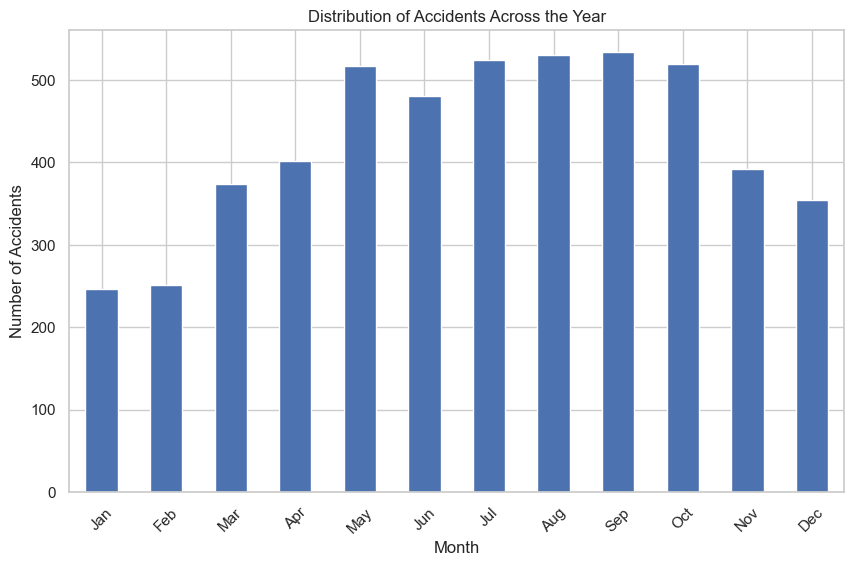

In [20]:
# Convert the crash_date column to datetime format for easier manipulation
df_accidents['crash_date'] = pd.to_datetime(df_accidents['crash_date'])

# Extract month and year from the crash date to analyze the distribution across the year
df_accidents['month'] = df_accidents['crash_date'].dt.month
df_accidents['year'] = df_accidents['crash_date'].dt.year

# Plot the distribution of accidents across months
plt.figure(figsize=(10, 6))
df_accidents['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Accidents Across the Year')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

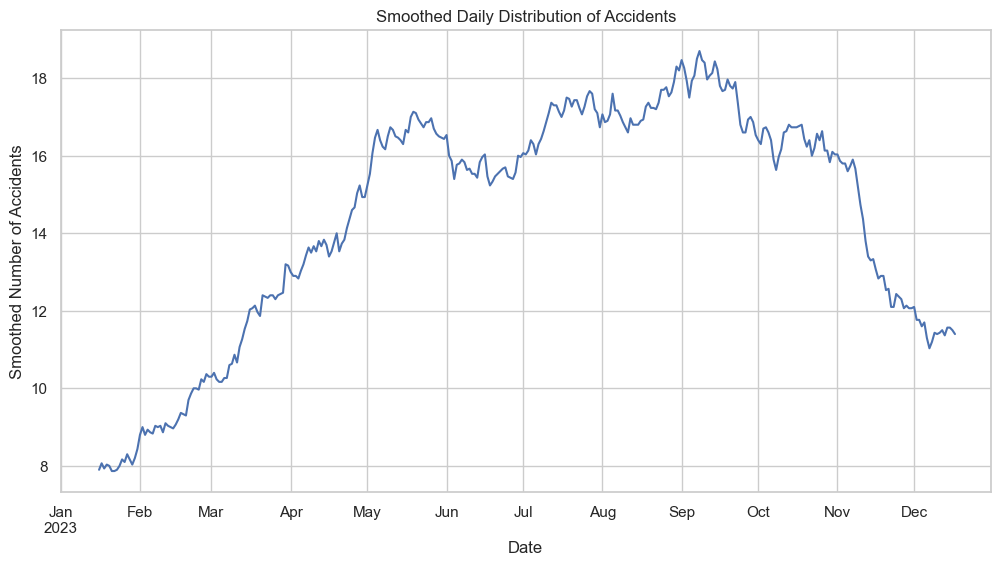

In [22]:
# Count accidents per day first
df_accidents_daily_counts = df_accidents.resample('D', on='crash_date').size()

# Apply a 30-day rolling mean for smoothing
monthly_smoothed = df_accidents_daily_counts.rolling(window=30, center=True).mean()

# Plotting the smoothed data
plt.figure(figsize=(12, 6))
monthly_smoothed.plot(kind='line')
plt.title('Smoothed Daily Distribution of Accidents')
plt.xlabel('Date')
plt.ylabel('Smoothed Number of Accidents')
#plt.ylim(0)
plt.show()

### Dataset 3: Count of cyclists in New York

In [24]:
# Define the date range
start_date = "2023-01-01" #"YYYY-MM-DD"
end_date = "2023-12-31"

# Socrata data ID and app token
data_id = "uczf-rk3c"
app_token = "stS0lve6TTmD6sGkuwdbI6Fhi"

# Construct the SQL query
sql_query = (
    f"SELECT date_trunc_ymd(date) as date, SUM(counts) as daily_counts "
    f"WHERE date between '{start_date}' and '{end_date}' "
    f"GROUP BY date ORDER BY date"
)

df_cyclists_nyc_daily = fetch_data(data_id=data_id, app_token=app_token, sql_query=sql_query)
df_cyclists_nyc_daily['daily_counts'] = df_cyclists_nyc_daily['daily_counts'].astype(int)

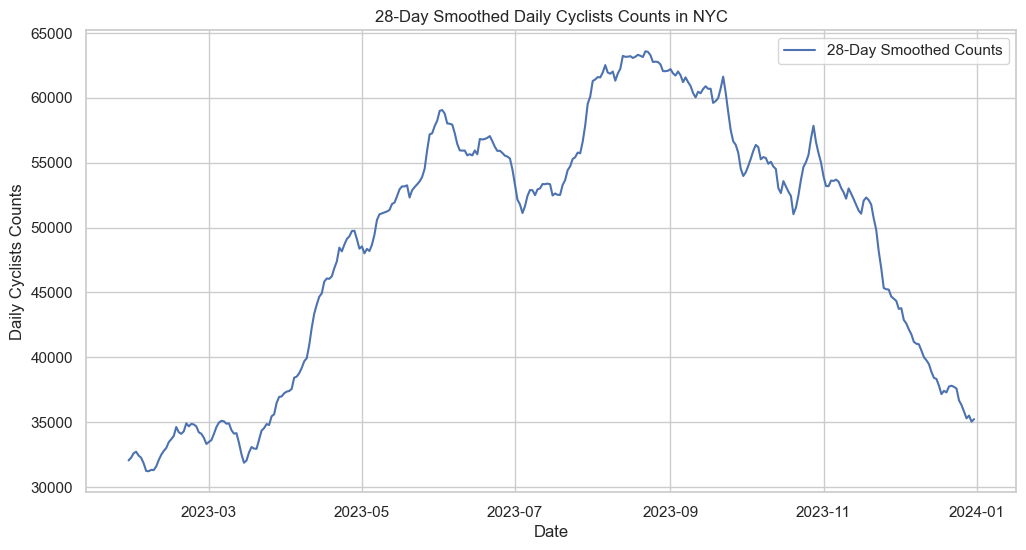

In [25]:
# Convert the date column to datetime if it's not already
df_cyclists_nyc_daily['date'] = pd.to_datetime(df_cyclists_nyc_daily['date'])

# Calculate the 28-day rolling average
df_cyclists_nyc_daily['daily_counts_smoothed'] = df_cyclists_nyc_daily['daily_counts'].rolling(window=28).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df_cyclists_nyc_daily['date'], df_cyclists_nyc_daily['daily_counts_smoothed'], label='28-Day Smoothed Counts')
plt.xlabel('Date')
plt.ylabel('Daily Cyclists Counts')
plt.title('28-Day Smoothed Daily Cyclists Counts in NYC')
plt.legend()
plt.show()

In [26]:
#Get bicycle counters information

# Socrata data ID and app token
data_id = "smn3-rzf9"
app_token = "stS0lve6TTmD6sGkuwdbI6Fhi"

# Construct the SQL query
sql_query = (
    f"SELECT *"
)

df_bicycle_counters = fetch_data(data_id=data_id, app_token=app_token, sql_query=sql_query)

In [30]:
# Initialize the map centered around New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10, tiles="CartoDB Positron")

# Iterate over the rows of df_bicycle_counters and add markers for each counter
for _, row in df_bicycle_counters.iterrows():
    # Extract information for each counter
    lat = row['latitude']
    lon = row['longitude']
    name = row['name']
    
    # Add a marker on the map for the counter
    folium.Marker(
        location=[lat, lon],
        popup=f"Counter: {name}",
        tooltip=name
    ).add_to(nyc_map)

# Display the map
nyc_map

Counters are not present in all of the city, also some counters don't record 24/7, So the total number of trips is not accurate. On the other side the distribution across the year matches the expected seasonal fluctutations. Since We found a good estimations on the NYC DOT website of the number of bike trips per year we can scale the recorded data to match the expected amplitude. (source https://www.nyc.gov/html/dot/html/bicyclists/cyclinginthecity.shtml )

In [31]:
number_of_bike_trips_nyc_2023 = 222700000
scale_factor = number_of_bike_trips_nyc_2023 / trip_data.count()
df_cyclists_nyc_daily['adjusted_daily_counts'] = df_cyclists_nyc_daily['daily_counts']*scale_factor

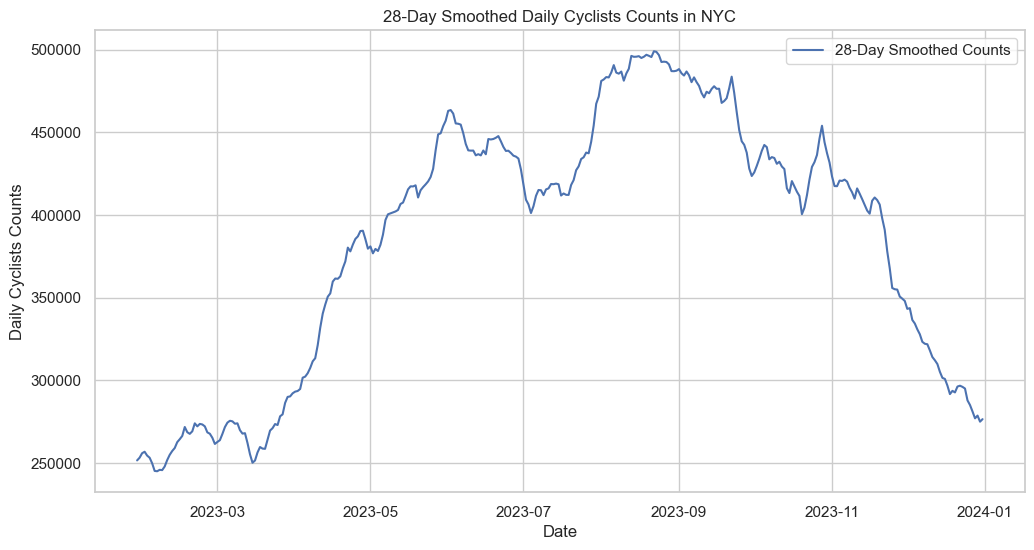

In [32]:
# Convert the date column to datetime if it's not already
df_cyclists_nyc_daily['date'] = pd.to_datetime(df_cyclists_nyc_daily['date'])

# Calculate the 28-day rolling average
df_cyclists_nyc_daily['adjusted_daily_counts_smoothed'] = df_cyclists_nyc_daily['adjusted_daily_counts'].rolling(window=28).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df_cyclists_nyc_daily['date'], df_cyclists_nyc_daily['adjusted_daily_counts_smoothed'], label='28-Day Smoothed Counts')
plt.xlabel('Date')
plt.ylabel('Daily Cyclists Counts')
plt.title('28-Day Smoothed Daily Cyclists Counts in NYC')
plt.legend()
plt.show()

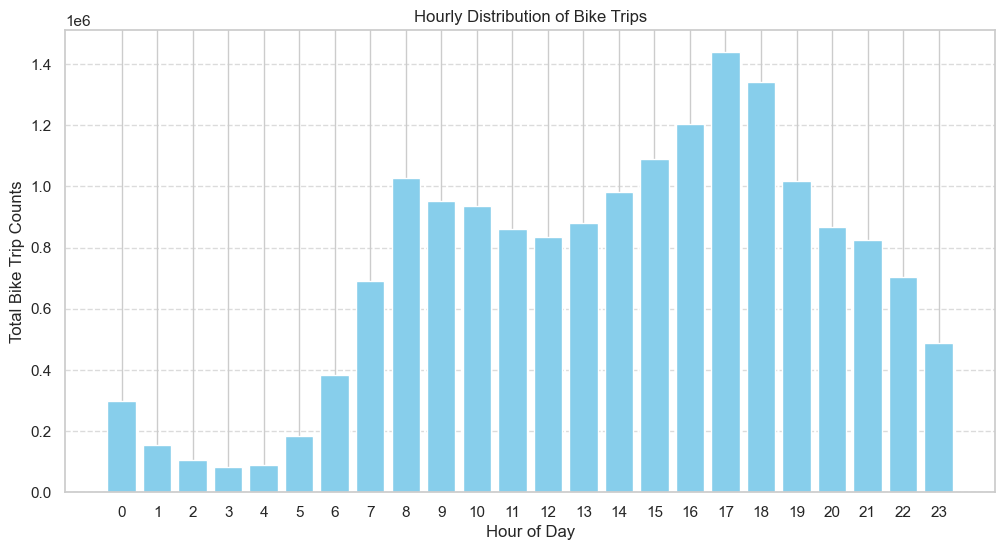

In [33]:
# Define the date range
start_date = "2023-01-01"  # Start date in "YYYY-MM-DD"
end_date = "2023-12-31"  # End date in "YYYY-MM-DD"

# Socrata data ID and app token
data_id = "uczf-rk3c"
app_token = "stS0lve6TTmD6sGkuwdbI6Fhi"

# Construct the SQL query using `date_extract_hh`
sql_query = (
    f"SELECT date_extract_hh(date) as hour, SUM(counts) as hourly_counts "
    f"WHERE date BETWEEN '{start_date}' AND '{end_date}' "
    f"GROUP BY hour ORDER BY hour"
)

# Fetch the hourly data
df_cyclists_nyc_hourly = fetch_data(data_id=data_id, app_token=app_token, sql_query=sql_query)
df_cyclists_nyc_hourly['hour'] = df_cyclists_nyc_hourly['hour'].astype(int)
df_cyclists_nyc_hourly['hourly_counts'] = df_cyclists_nyc_hourly['hourly_counts'].astype(int)

plt.figure(figsize=(12, 6))
plt.bar(df_cyclists_nyc_hourly['hour'], df_cyclists_nyc_hourly['hourly_counts'], color='skyblue')
plt.xlabel('Hour of Day')
plt.ylabel('Total Bike Trip Counts')
plt.title('Hourly Distribution of Bike Trips')
plt.xticks(range(0, 24))  # Set x-ticks from 0 to 23 for each hour
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Risk Estimation

We will assume that the data of counts of cyclists in New york is accurate and corresponds to all bicycle trips in new york.

In [34]:
#average risk over one year:
nb_accidents = len(df_accidents)
nb_trips_nyc = df_cyclists_nyc_daily['adjusted_daily_counts'].sum()
avg_risk_per_trip = nb_accidents/nb_trips_nyc

print(f"Average Risk of KSI per Trip in 2023: {avg_risk_per_trip}")

Average Risk of KSI per Trip in 2023: 3.73915189499266e-05


In [41]:
nb_accidents

5125

In [35]:
# Average Risk per Minute of Biking
average_trip_duration = trip_data.agg(F.avg('duration_minutes')).collect()[0][0]
avg_risk_per_biking_minute = nb_accidents/(average_trip_duration*nb_trips_nyc)
print(f"Average Risk of KSI per Minute of Biking in 2023: {avg_risk_per_biking_minute}")

Average Risk of KSI per Minute of Biking in 2023: 2.362483535080795e-06


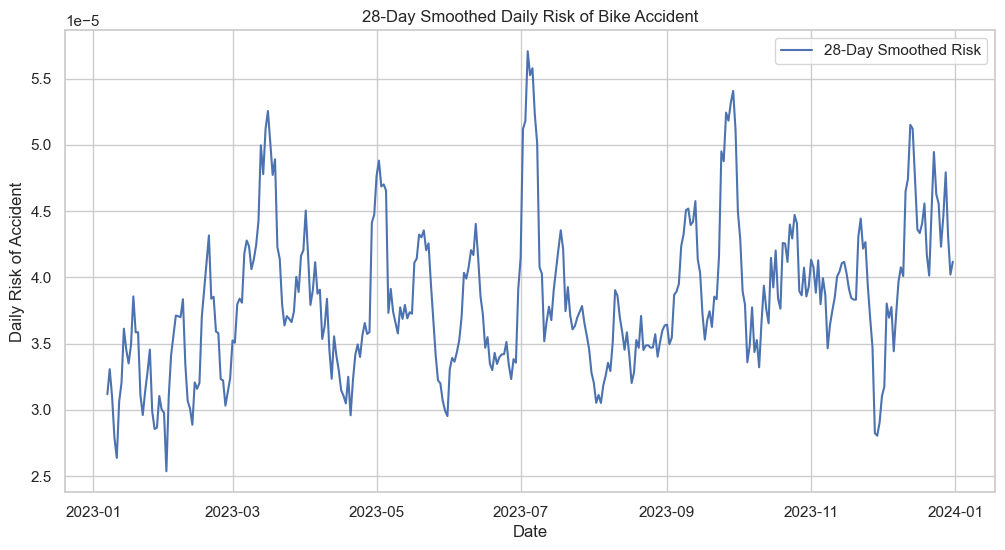

In [36]:
df_accidents_daily_counts = df_accidents['crash_date'].value_counts().reset_index()
df_accidents_daily_counts.columns = ['date', 'crash_count']  # Rename columns for clarity
df_accidents_daily_counts['date'] = pd.to_datetime(df_accidents_daily_counts['date'])

# Step 2: Ensure df_cyclists_nyc_daily['date'] is in datetime format for proper merging
df_cyclists_nyc_daily['date'] = pd.to_datetime(df_cyclists_nyc_daily['date'])

# Step 3: Merge the two DataFrames on 'date' with an inner join
estimated_daily_risk_df = pd.merge(
    df_cyclists_nyc_daily[['date', 'adjusted_daily_counts']],
    df_accidents_daily_counts[['date', 'crash_count']],
    on='date',
    how='inner'
)

estimated_daily_risk_df['estimated_daily_risk'] = estimated_daily_risk_df['crash_count'] / estimated_daily_risk_df['adjusted_daily_counts']

# Convert the date column to datetime if it's not already
estimated_daily_risk_df['date'] = pd.to_datetime(estimated_daily_risk_df['date'])

# Calculate the 28-day rolling average
estimated_daily_risk_df['estimated_daily_risk_smoothed'] = estimated_daily_risk_df['estimated_daily_risk'].rolling(window=7).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(estimated_daily_risk_df['date'], estimated_daily_risk_df['estimated_daily_risk_smoothed'], label='28-Day Smoothed Risk')
plt.xlabel('Date')
plt.ylabel('Daily Risk of Accident')
plt.title('28-Day Smoothed Daily Risk of Bike Accident')
plt.legend()
plt.show()

C:\Users\azizt\AppData\Local\Temp\ipykernel_13076\234141441.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_accidents['hour'] = pd.to_datetime(df_accidents['crash_time']).dt.hour


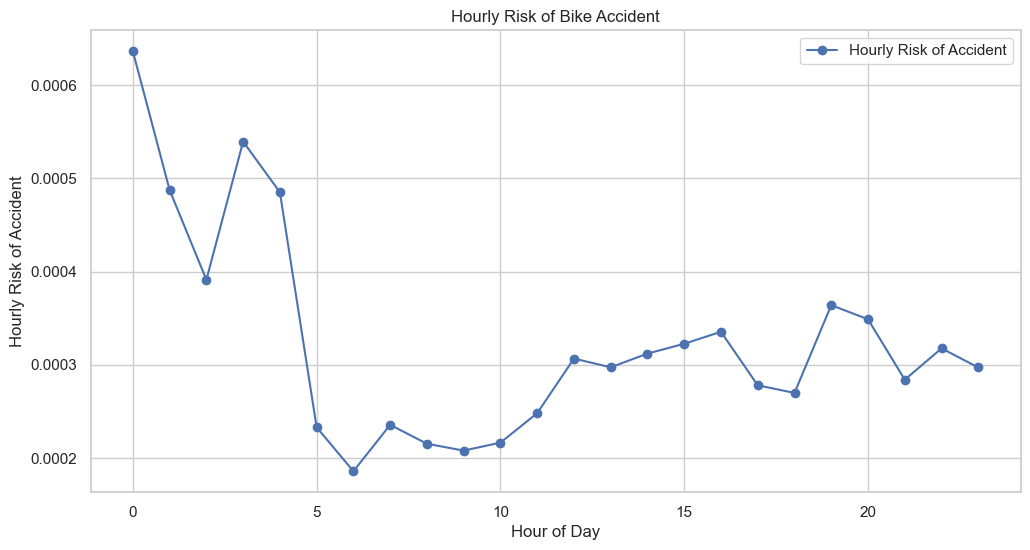

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'crash_datetime' is the timestamp column for accidents, and 'cyclist_datetime' for cyclist counts

# Step 1: Extract hour information for both accidents and cyclist data
df_accidents['hour'] = pd.to_datetime(df_accidents['crash_time']).dt.hour
#df_cyclists_nyc_daily['hour'] = pd.to_datetime(df_cyclists_nyc_daily['date']).dt.hour

# Step 2: Group accidents and cyclist counts by hour
hourly_accidents = df_accidents.groupby('hour').size().reset_index(name='hourly_crash_count')
#hourly_cyclists = df_cyclists_nyc_daily.groupby('hour')['adjusted_daily_counts'].sum().reset_index(name='hourly_cyclist_count')

# Step 3: Merge the two DataFrames on 'hour'
hourly_risk_df = pd.merge(hourly_accidents, df_cyclists_nyc_hourly, on='hour', how='inner')

# Step 4: Calculate hourly risk
hourly_risk_df['hourly_risk'] = hourly_risk_df['hourly_crash_count'] / hourly_risk_df['hourly_counts']

# Step 5: Plot hourly risk
plt.figure(figsize=(12, 6))
plt.plot(hourly_risk_df['hour'], hourly_risk_df['hourly_risk'], marker='o', linestyle='-', label='Hourly Risk of Accident')
plt.xlabel('Hour of Day')
plt.ylabel('Hourly Risk of Accident')
plt.title('Hourly Risk of Bike Accident')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../results/Time_of_day_factor_risk.jpg')
plt.show()


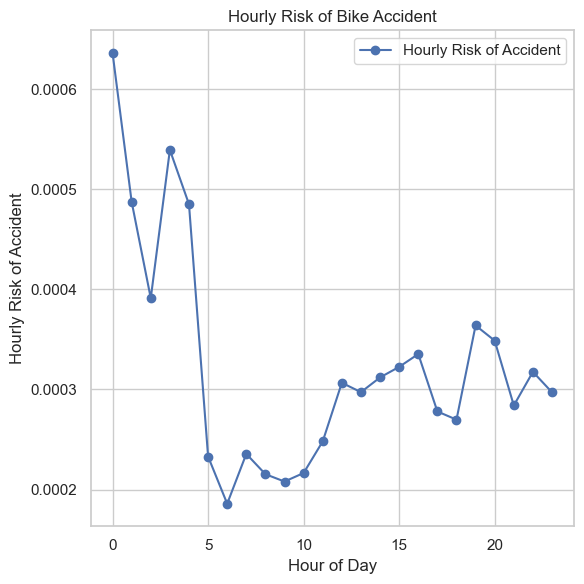

In [88]:
# Step 5: Plot hourly risk
plt.figure(figsize=(6, 6))
plt.plot(hourly_risk_df['hour'], hourly_risk_df['hourly_risk'], marker='o', linestyle='-', label='Hourly Risk of Accident')
plt.xlabel('Hour of Day')
plt.ylabel('Hourly Risk of Accident')
plt.title('Hourly Risk of Bike Accident')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../results/Time_of_day_factor_risk.jpg')
plt.show()

In [39]:
nb_trip_citibike = trip_data.count()
Nb_accidents_citibike_estimated = nb_trip_citibike*avg_risk_per_trip

print(f"Estimation of Citibike Accidents in 2023: {Nb_accidents_citibike_estimated}")

Estimation of Citibike Accidents in 2023: 1061.1760191303044


In [40]:
# cost estimation
cost_repare_classic_bike = 1000 #euro
cost_repare_electric_bike = 2000 #euro
anteil_electric_bike = rideable_counts_pd[rideable_counts_pd['rideable_type'] == 'electric_bike']['count'].values[0]/nb_trip_citibike
anteil_classic_bike = rideable_counts_pd[rideable_counts_pd['rideable_type'] == 'classic_bike']['count'].values[0]/nb_trip_citibike
total_cost = Nb_accidents_citibike_estimated*(anteil_electric_bike*cost_repare_electric_bike+anteil_classic_bike*cost_repare_classic_bike)

print(f"Estimated Total Cost Damage Repair Of accideted Citibikes: {total_cost}")

Estimated Total Cost Damage Repair Of accideted Citibikes: 1606500.8489270394
